In [1]:
 
!pip install statsmodels --user  
!pip install tensorboardX --user
!pip install pandas --user
!pip install plotly
!pip install bs4 --user
!pip install plotly --user
!pip install -U auquan_toolbox —user

ERROR: Invalid requirement: '—user'


In [2]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

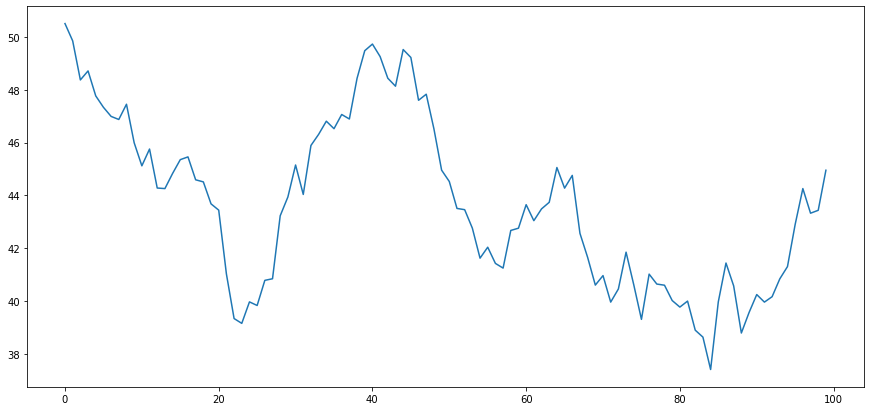

In [3]:
# Generate the daily returns
Xreturns = np.random.normal(0, 1, 100) 
# sum them and shift all the prices up
X = pd.Series(np.cumsum(Xreturns), name='X') + 50
X.plot(figsize=(15,7))
plt.show()

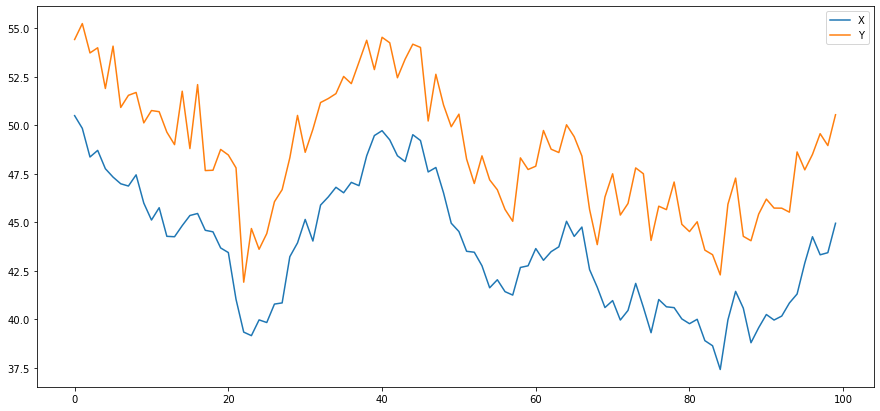

In [4]:
noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot(figsize=(15,7))
plt.show()

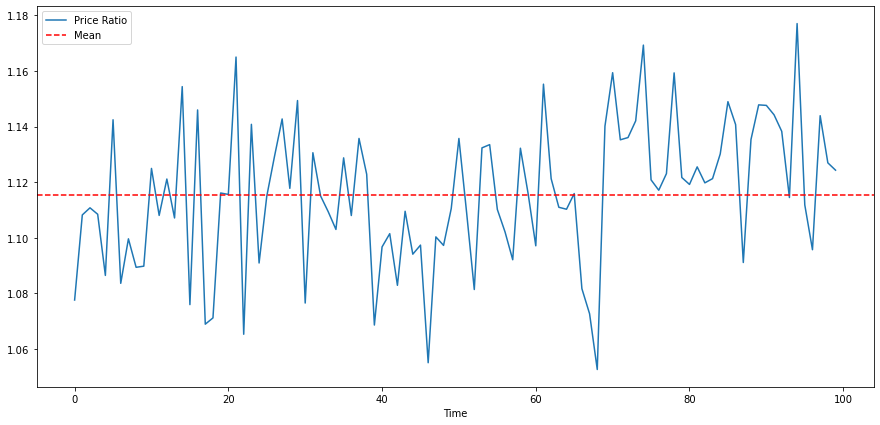

In [5]:
(Y/X).plot(figsize=(15,7)) 
plt.axhline((Y/X).mean(), color='red', linestyle='--') 
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])
plt.show()


In [6]:
score, pvalue, _ = coint(X,Y)
print(pvalue) ## returns 


2.0503418653412224e-16


In [16]:
!pip install yfinance

from datetime import datetime
import yfinance as yf



In [35]:
stock_list = ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM','HPQ','JNPR','AMD','IBM']
print('stock_list:', stock_list)
ds = yf.download(stock_list, start="2007-12-01", end="2017-12-01")
print('data fields downloaded:', set(ds.columns.get_level_values(0)))



stock_list: ['SPY', 'AAPL', 'ADBE', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM']
[*********************100%***********************]  10 of 10 completed
data fields downloaded: {'Open', 'Close', 'High', 'Volume', 'Adj Close', 'Low'}


In [36]:
data=ds['Adj Close']
data.head()

,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,QCOM,SPY
Date,,,,,,,,,,
2007-11-30,5.587751,42.139999,9.76,13.588712,16.936790,69.221031,25.110785,24.943214,28.917395,112.334290
2007-12-03,5.484718,42.689999,9.66,13.353655,16.698431,69.648804,25.659975,24.438410,28.335924,111.593742
2007-12-04,5.513852,43.320000,9.25,13.345551,16.787819,70.175301,25.693773,24.327059,27.910463,110.596321
2007-12-05,5.688332,43.900002,8.91,13.515762,17.102316,71.182220,26.445744,25.351517,28.728848,112.447632
2007-12-06,5.824792,44.540001,9.07,13.685978,17.284399,72.195740,26.403494,25.648455,28.757313,114.057152


In [46]:
keys=data.keys()
keys[1]

'ADBE'

In [47]:

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.10:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


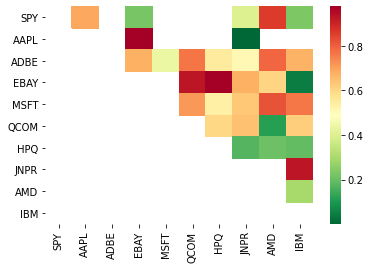

[('ADBE', 'MSFT'), ('EBAY', 'SPY')]


In [51]:
# Heatmap to show the p-values of the cointegration test between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=stock_list, 
                yticklabels=stock_list, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)


pvalue = 0.0018311492115046797


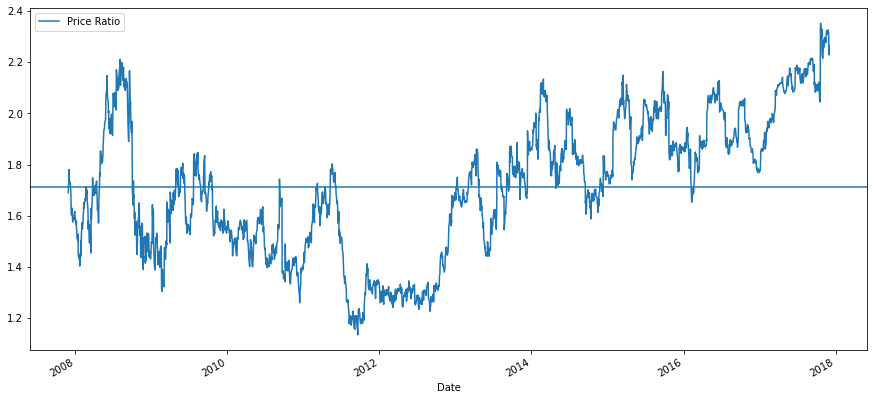

In [52]:

S1 = data['ADBE']
S2 = data['MSFT']
score, pvalue, _ = coint(S1, S2)
print('pvalue =',pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()



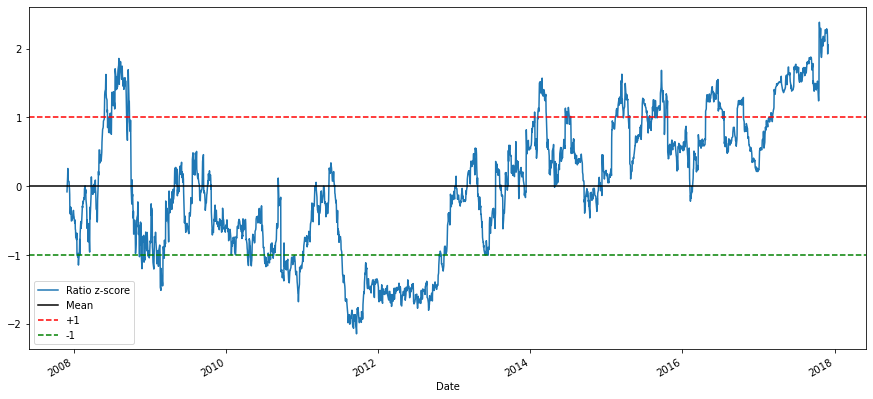

In [53]:
def zscore(series):
    return (series - series.mean()) / np.std(series)
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

2519


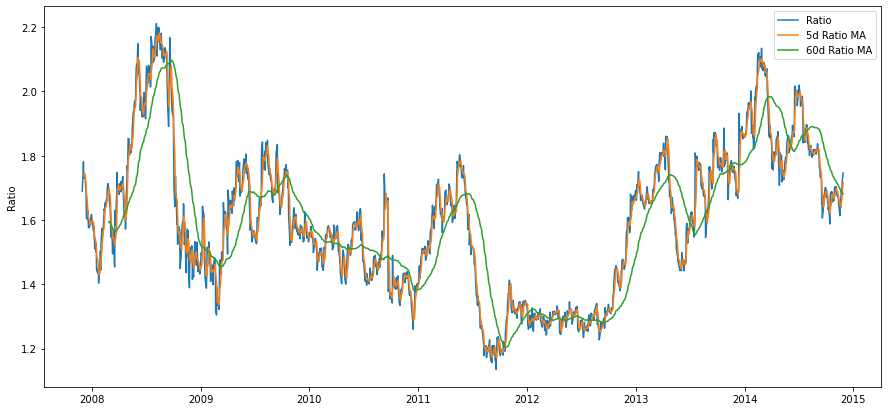

In [54]:
ratios = data['ADBE'] / data['MSFT']
print(len(ratios))
train = ratios[:1762]
test = ratios[1762:]
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

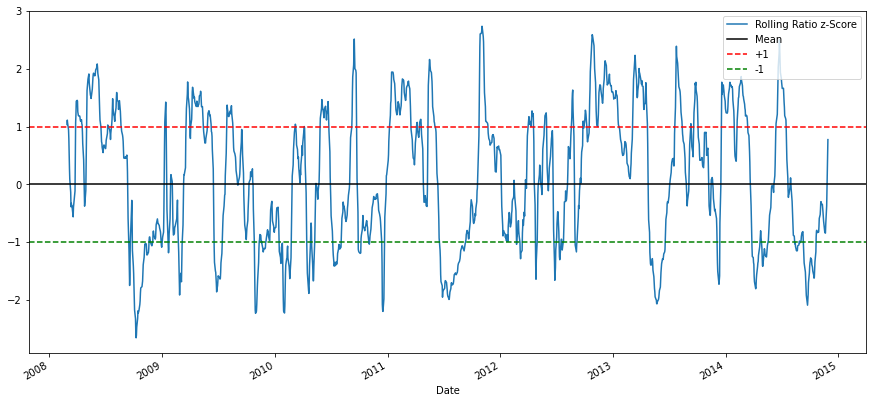

In [55]:

# Take a rolling 60 day standard deviation
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'
# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()


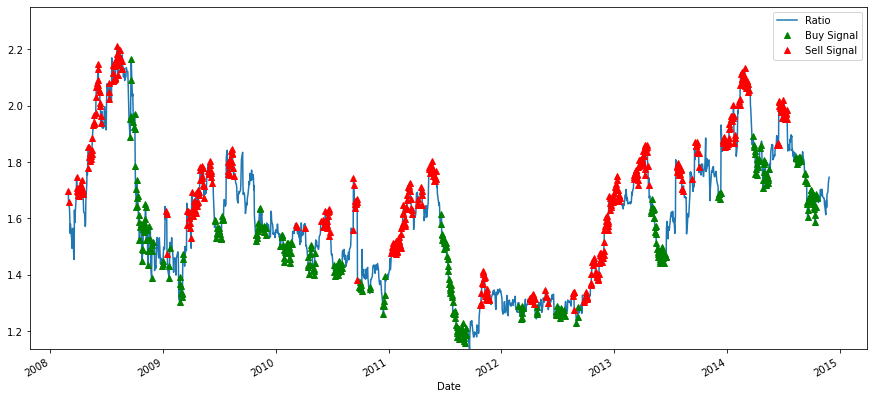

In [56]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()


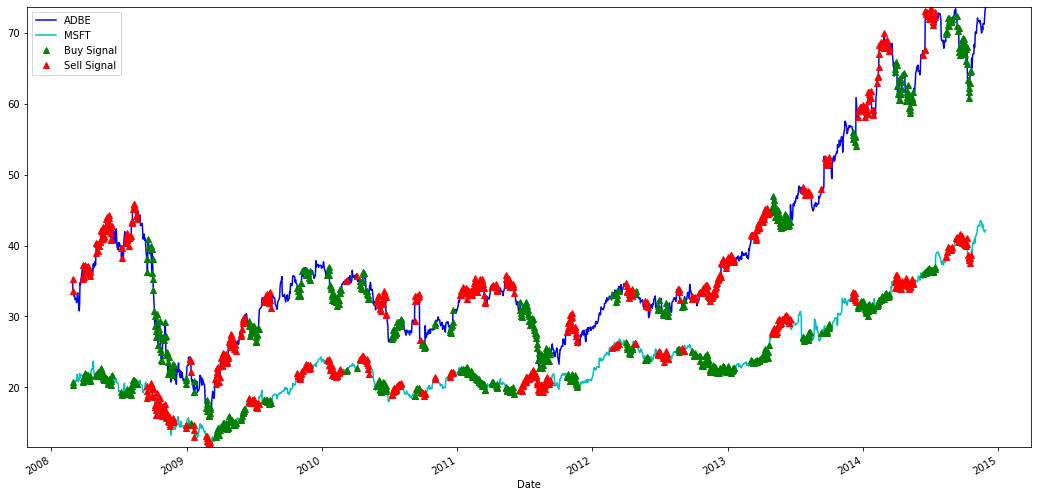

In [57]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = data['ADBE'].iloc[:1762]
S2 = data['MSFT'].iloc[:1762]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['ADBE','MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()


In [60]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money

trade(data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762], 5, 60)

631.8337841175611

In [61]:


trade(data['ADBE'].iloc[1762:], data['MSFT'].iloc[1762:], 5, 90)

1180.9652662683438

In [62]:


# Find the window length 0-254 
# that gives the highest returns using this strategy
length_scores = [trade(data['ADBE'].iloc[:1762], 
                data['MSFT'].iloc[:1762], 5, l) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)


Best window length: 246


In [63]:
# Find the returns for test data
# using what we think is the best window length
length_scores2 = [trade(data['ADBE'].iloc[1762:], 
                  data['MSFT'].iloc[1762:],5, l) 
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

246 day window: 987.0024406378064
191 day window: 1572.200552803651


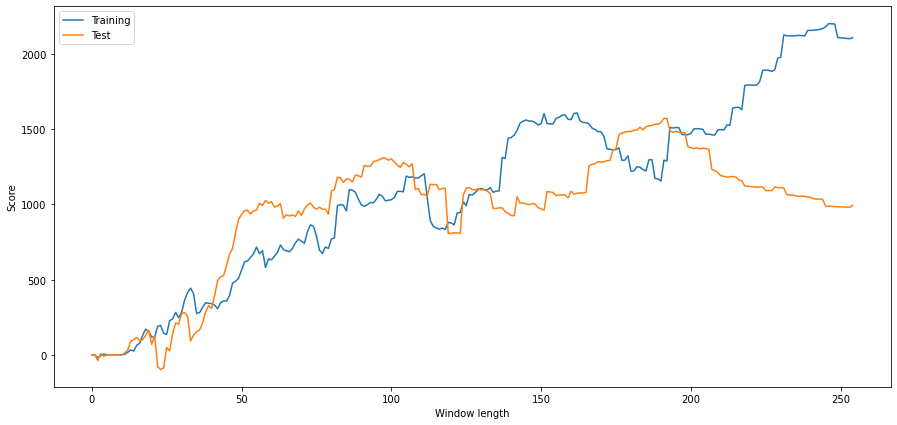

In [64]:


plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()
